In [1]:
import sys
sys.path.append('..')

In [2]:
from src.models.mlp import MLP

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset
from pathlib import Path


class RawSignalDataset(Dataset):
    def __init__(self, root_dir: str):
        self.samples = []
        self.labels = []

        root = Path(root_dir)
        class_dirs = sorted(root.iterdir())

        for label, class_dir in enumerate(class_dirs):
            for file in class_dir.glob("*.npy"):
                self.samples.append(file)
                self.labels.append(label)

        # infer signal length from first file
        sample = np.load(self.samples[0])
        self.signal_length = sample.shape[0]


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        signal = np.load(self.samples[idx]).astype(np.float32)
        signal = torch.from_numpy(signal)

        # Flatten for MLP
        signal = signal.view(-1)

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return signal, label


In [4]:
from torch.utils.data import DataLoader, random_split
import os

cwd = Path(os.getcwd()).parent
dataset = RawSignalDataset(Path(cwd, "data", "raw"))

n = len(dataset)
train_size = int(0.6 * n)
val_size = int(0.2 * n)
test_size = n - train_size - val_size

train_ds, val_ds, test_ds = random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [5]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)
print(dataset.signal_length)

torch.Size([32, 5000]) torch.Size([32])
5000


### Training

In [6]:
## Training the model
from torch import nn, optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_dim=dataset.signal_length, num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [8]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return total_loss / len(loader), correct / total


In [9]:
num_epochs = 100
patience = 5

best_val_loss = float("inf")
epochs_no_improve = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train loss: {train_loss:.4f} | "
        f"Val loss: {val_loss:.4f} | "
        f"Val acc: {val_acc:.3f}"
    )

    # early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(
            f"Stopping early at epoch {epoch+1} "
            f"(no val loss improvement for {patience} epochs)"
        )
        break


Epoch 01 | Train loss: 1.1709 | Val loss: 0.4298 | Val acc: 0.828
Epoch 02 | Train loss: 0.4141 | Val loss: 0.2735 | Val acc: 0.792
Epoch 03 | Train loss: 0.2915 | Val loss: 0.2582 | Val acc: 0.792
Epoch 04 | Train loss: 0.2745 | Val loss: 0.2309 | Val acc: 0.828
Epoch 05 | Train loss: 0.4248 | Val loss: 1.9642 | Val acc: 0.408
Epoch 06 | Train loss: 0.4680 | Val loss: 0.2268 | Val acc: 0.828
Epoch 07 | Train loss: 0.2696 | Val loss: 0.2276 | Val acc: 0.828
Epoch 08 | Train loss: 0.2732 | Val loss: 0.2175 | Val acc: 0.828
Epoch 09 | Train loss: 0.2667 | Val loss: 0.2085 | Val acc: 0.828
Epoch 10 | Train loss: 0.2810 | Val loss: 0.2292 | Val acc: 0.792
Epoch 11 | Train loss: 0.2834 | Val loss: 0.2157 | Val acc: 1.000
Epoch 12 | Train loss: 0.2660 | Val loss: 0.1585 | Val acc: 1.000
Epoch 13 | Train loss: 0.2749 | Val loss: 0.1840 | Val acc: 1.000
Epoch 14 | Train loss: 0.2665 | Val loss: 0.2120 | Val acc: 0.792
Epoch 15 | Train loss: 0.2458 | Val loss: 0.2137 | Val acc: 0.792
Epoch 16 |

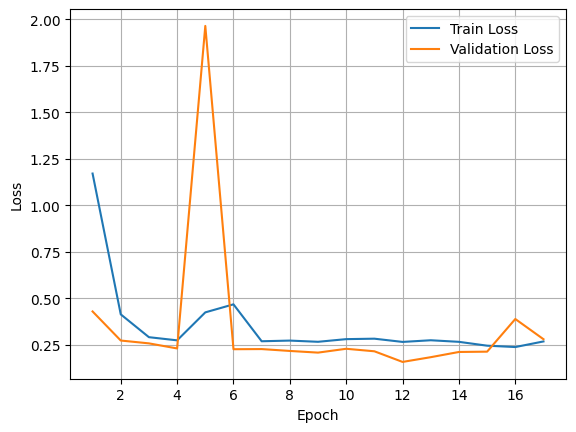

In [10]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_losses) + 1)

plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Evaluate

In [11]:
test_loss, test_acc = evaluate(
    model, test_loader, criterion, device
)

print(f"Test accuracy (raw signal): {test_acc:.3f}")

Test accuracy (raw signal): 0.808


In [12]:
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())

    return (
        np.concatenate(all_labels),
        np.concatenate(all_preds),
    )

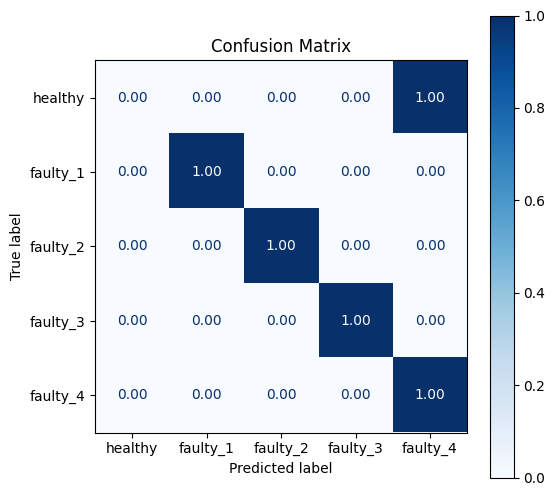

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true, y_pred = get_predictions(model, test_loader, device)

cm = confusion_matrix(y_true, y_pred, normalize="true")

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["healthy", "faulty_1", "faulty_2", "faulty_3", "faulty_4"]  # list like ["healthy", "faulty_1", ...]
)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix")
plt.show()

In [14]:
torch.save(model.state_dict(), "model-mlp-no-preprocessing.pth")